In [1]:
!pip uninstall -y torch torchvision torchaudio torchdata dgl
!pip install torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 torchdata==0.7.1 dgl==2.1.0


Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
Found existing installation: torchdata 0.11.0
Uninstalling torchdata-0.11.0:
  Successfully uninstalled torchdata-0.11.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.4/755.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.2 MB/s eta 0:00:00

In [2]:
!pip install "numpy<2" --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 50.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
torchtune 0.6.1 requires torchdata==0.11.0, but you have torchdata 0.7.1 which is incompat

In [1]:
import pandas as pd
import numpy as np
import os
from time import time
os.environ['DGLBACKEND'] = 'pytorch'
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import dgl
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
import numpy, torch, dgl, torchdata
print("NumPy:", numpy.__version__)
print("Torch:", torch.__version__)
print("TorchData:", torchdata.__version__)
print("DGL:", dgl.__version__)

NumPy: 1.26.4
Torch: 2.2.0+cu121
TorchData: 0.7.1
DGL: 2.1.0


In [4]:
transactions_df = pd.read_csv('train_transaction.csv')
num_transactions = transactions_df.shape[0]
print("number of transactions: ", num_transactions)
print(f"proportion of fraudulent transaction: {transactions_df.isFraud.value_counts(normalize=True)[1]:.4f}")
identity_df = pd.read_csv('train_identity.csv')
print("dataframe")
print(transactions_df.head())
print(identity_df.head())

number of transactions:  32677
proportion of fraudulent transaction: 0.0285
dataframe
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0

In [5]:
SPLIT_RATIO = 0.70
n_train = int(transactions_df.shape[0]*SPLIT_RATIO)
print(n_train)

22873


In [6]:
train_ids = transactions_df.TransactionID[:n_train]
val_ids = transactions_df.TransactionID[n_train:]

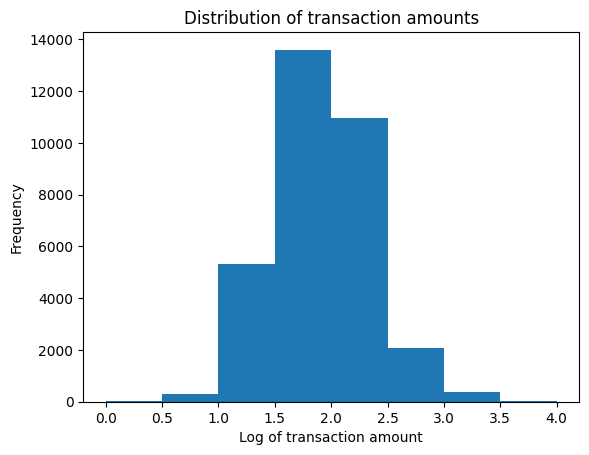

In [7]:
id_columns = ['card1','card2','card3','card4','card5','card6','ProductCD','addr1','addr2','P_emaildomain','R_emaildomain']
cat_columns = ['M1','M2','M3','M4','M5','M6','M7','M8','M9']
transactions_non_features = ['isFraud','TransactionDT'] + id_columns
features_cols = [col for col in transactions_df.columns if col not in transactions_non_features]
features_df = pd.get_dummies(transactions_df[features_cols], columns=cat_columns).fillna(0)
features_df['TransactionAmt'] = features_df['TransactionAmt'].apply(np.log10)
features_df['TransactionAmt'].plot(kind='hist', bins=[0,0.5,1,1.5,2,2.5,3,3.5,4])
plt.title('Distribution of transaction amounts')
plt.xlabel('Log of transaction amount')
plt.show()
labels_df = transactions_df[['TransactionID','isFraud']]
node_types = id_columns + list(identity_df.columns)
node_types.remove('TransactionID')
full_identity_df = identity_df.merge(transactions_df[id_columns+['TransactionID']], on='TransactionID', how='right')
edge_dfs = {}
for ntype  in node_types:
    edge_dfs[ntype] = full_identity_df[['TransactionID', ntype]].dropna()

In [9]:
id_to_node = {}
id_to_node['target'] = dict([(v,k) for k,v in dict(transactions_df['TransactionID']).items()])
for ntype in node_types:
    new_nodes_ids = edge_dfs[ntype][ntype].unique()
    new_nodes_dgl = np.arange(len(new_nodes_ids)+1)
    id_to_node[ntype] = { a:b for a,b in zip(new_nodes_ids, new_nodes_dgl)}
id_to_node['card4']
edgelists = {}
num_nodes_dict = {}
for ntype in node_types:
    edge_type = ('target','target<>'+ntype,ntype)
    rev_edge_type = (ntype, ntype+'<>target','target')
    source_nodes = edge_dfs[ntype]['TransactionID'].apply(lambda a : id_to_node['target'][a]).to_numpy()
    destination_nodes = edge_dfs[ntype][ntype].apply(lambda a : id_to_node[ntype][a]).to_numpy()
    edgelists[edge_type] = ( source_nodes, destination_nodes )
    edgelists[rev_edge_type] = (destination_nodes, source_nodes)
    num_nodes_dict[ntype] = len(np.unique(destination_nodes))
source_nodes = edge_dfs[ntype]['TransactionID'].apply(lambda a : id_to_node['target'][a]).to_numpy()
edgelists[('target','target<>target','target')] = (source_nodes,source_nodes)
num_nodes_dict['target'] = num_transactions

In [10]:
g = dgl.heterograph(edgelists, num_nodes_dict)

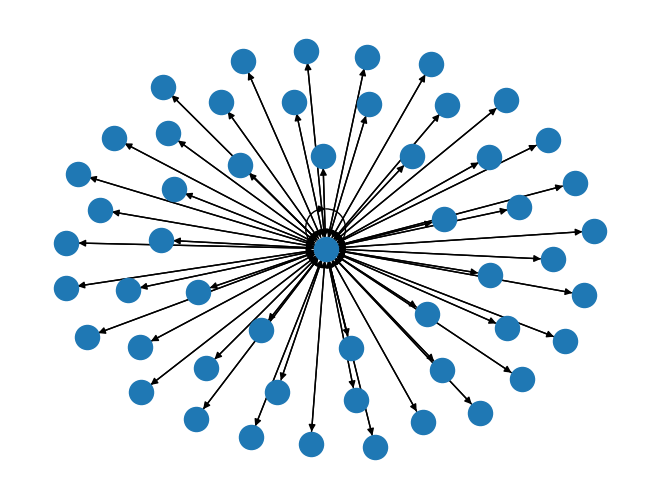

In [11]:
meta = g.metagraph()
nx.draw(meta)

In [12]:
features_df.head()
features_df.dtypes

,0
TransactionID,int64
TransactionAmt,float64
dist1,float64
dist2,float64
C1,float64
...,...
M7_T,bool
M8_F,bool
M8_T,bool
M9_F,bool


In [13]:
features_df = features_df.astype({col: 'int8' for col in features_df.select_dtypes('bool').columns})
X = features_df.drop('TransactionID', axis=1)
X_np = X.to_numpy(dtype=np.float32)
feature_tensor = torch.from_numpy(X_np)
g.nodes['target'].data['features'] = feature_tensor
print(feature_tensor.shape, feature_tensor.dtype)
feature_tensor = torch.from_numpy(features_df.drop('TransactionID', axis=1).to_numpy())
g.nodes['target'].data['features'] = feature_tensor

torch.Size([32677, 389]) torch.float32


In [14]:
trial = 1515
orig_feat = torch.from_numpy(features_df.iloc[trial,1:].to_numpy())
graph_feat = g.ndata['features']['target'][trial]
assert max(orig_feat - graph_feat) == 0
print('Feature vectors match. Check is good!')
train_mask = [ id_to_node['target'][x] for x in train_ids]
val_mask = [ id_to_node['target'][x] for x in val_ids]
labels = torch.tensor(labels_df['isFraud'].to_numpy()).float()
mean = torch.mean(g.ndata['features']['target'], axis=0)
std = torch.sqrt(torch.sum((g.ndata['features']['target'] - mean)**2, axis=0)/g.ndata['features']['target'].shape[0])
g.ndata['features']['target'] = (g.ndata['features']['target'] - mean)/std

Feature vectors match. Check is good!


In [15]:
INPUT_DIM = 8
HIDDEN_DIM = 8
TARGET_OUT_DIM = 8
CONV_LAYERS = 2
TARGET_PREPROCESSING_HIDDEN_DIM = 32
TARGET_PREPROCESSING_NO_LAYERS = 3
TARGET_POSTPROCESSING_HIDDEN_DIM = 8
TARGET_POSTPROCESSING_NO_LAYERS = 2
LEARNING_RATE = 0.001
LOSS_MULTIPLIER = 15
NUM_EPOCHS = 150

In [16]:
from dgl.nn.pytorch import HeteroGraphConv, HeteroEmbedding, GraphConv
from torch.nn import Linear
target_feature_dim = g.ndata['features']['target'].shape[1]
num_embeddings_dict = { src : g.num_nodes(src) for (src,etype,dst) in g.canonical_etypes if (dst == 'target' and src != 'target')}
class ff_block(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, n_layers):
        super().__init__()
        self.input_layer = Linear(in_dim, hidden_dim)
        self.hidden_layer = Linear(hidden_dim, hidden_dim)
        self.output_layer = Linear(hidden_dim, out_dim)
        self.n_layers = n_layers
    def forward(self, in_feats):
        h = self.input_layer(in_feats)
        h = nn.ReLU()(h)
        for i in range(1, self.n_layers):
            h = self.hidden_layer(h)
            h = nn.ReLU()(h)
        h = self.output_layer(h)
        return h
class RGCN(nn.Module):
    def __init__(self, target_feature_dim, in_dim, hidden_dim, conv_out_dim, num_conv_layers, num_embeddings, target_pre_h_dim, target_pre_layers, target_post_h_dim, target_post_layers):
        super().__init__()
        entry_module_dict = { etype : GraphConv(in_feats=in_dim, out_feats=hidden_dim) for etype in g.etypes}
        hidden_model_dict = { etype : GraphConv(in_feats=hidden_dim, out_feats=hidden_dim) for etype in g.etypes}
        final_model_dict1 = { etype : GraphConv(in_feats=hidden_dim, out_feats=conv_out_dim) for src,etype,dst in g.canonical_etypes if dst == 'target'}
        final_model_dict2 = { etype : GraphConv(in_feats=hidden_dim, out_feats=1) for src,etype,dst in g.canonical_etypes if dst != 'target'}
        final_model_dict = {**final_model_dict1, **final_model_dict2}
        self.num_conv_layers = num_conv_layers
        self.embed_layer = HeteroEmbedding(num_embeddings, in_dim)
        self.target_preprocessing = ff_block(target_feature_dim, target_pre_h_dim, in_dim, target_pre_layers)
        self.conv1 = HeteroGraphConv(entry_module_dict, aggregate = 'sum')
        self.conv2 = HeteroGraphConv(hidden_model_dict, aggregate = 'sum')
        self.conv3 = HeteroGraphConv(final_model_dict, aggregate = 'sum')
        self.target_postprocessing = ff_block(conv_out_dim, target_post_h_dim, 1, target_post_layers)
    def forward(self, graph, input_features):
        embeds = self.embed_layer({ ntype : graph.nodes(ntype) for ntype in node_types })
        input_features = input_features.to(dtype=torch.float32)
        target_features = self.target_preprocessing(input_features)
        embeds['target'] = target_features
        h = self.conv1(graph, embeds)
        h = {k: F.relu(v) for k, v in h.items()}
        for i in range(2, self.num_conv_layers):
            h = self.conv2(graph, h)
            h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv3(graph, h)
        h['target'] = self.target_postprocessing(h['target'])
        return h

In [17]:
model = RGCN(
    target_feature_dim = target_feature_dim,
    in_dim = INPUT_DIM,
    hidden_dim = HIDDEN_DIM,
    conv_out_dim = TARGET_OUT_DIM,
    num_conv_layers = CONV_LAYERS,
    num_embeddings = num_embeddings_dict,
    target_pre_h_dim = TARGET_PREPROCESSING_HIDDEN_DIM,
    target_pre_layers = TARGET_PREPROCESSING_NO_LAYERS,
    target_post_h_dim = TARGET_POSTPROCESSING_HIDDEN_DIM,
    target_post_layers = TARGET_POSTPROCESSING_NO_LAYERS
)
print('Number of parameters in the model: ')

Number of parameters in the model: 


In [18]:
print(' '*33,sum(param.numel() for param in model.parameters()))
weight_vector = (torch.ones(labels[train_mask].shape)+labels[train_mask]*LOSS_MULTIPLIER).reshape((labels[train_mask].shape[0],1))
val_weight_vector = (torch.ones(labels[val_mask].shape)+labels[val_mask]*LOSS_MULTIPLIER).reshape((labels[val_mask].shape[0],1))
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.BCELoss(weight_vector)
val_loss_fn = torch.nn.BCELoss(val_weight_vector)

                                  161604


In [19]:
def train_one_epoch(epoch_no, model, g, features, labels, train_mask, val_mask, threshold, return_probs=False):
    t0 = time()
    logits_dict = model(g, features)
    logits = logits_dict['target']
    del logits_dict
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
    labels = labels.reshape_as(preds)
    loss = loss_fn(probs[train_mask], labels[train_mask])
    with torch.no_grad():
        val_loss = val_loss_fn(probs[val_mask], labels[val_mask])
    train_acc = (preds[train_mask] == labels[train_mask]).float().mean()
    val_acc = (preds[val_mask] == labels[val_mask]).float().mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if return_probs:
        return loss, val_loss, train_acc, val_acc, time()-t0, probs, preds
    else:
        return loss, val_loss, train_acc, val_acc, time()-t0
def loss_history_plot(loss_history, val_loss_history=None, small=False):
    if small:
        size = (5,2)
    else:
        size = (7,4)
    fig, ax =plt.subplots(1,1,figsize=size)
    ax.plot(loss_history, label='Train')
    if val_loss_history:
        ax.plot(val_loss_history, label='Val')
        ax.legend()
    plt.show()

In [20]:
def train(model, g, num_epochs, labels, train_mask, val_mask, threshold):
    best_val_acc = 0
    epoch_times = []
    history = {}
    history['loss'] = []
    history['val_loss'] = []
    history['val_acc'] = []
    features = g.nodes['target'].data['features']
    for epoch in range(num_epochs):
        if epoch < num_epochs-1:
            loss, val_loss, train_acc, val_acc, epoch_time = train_one_epoch(epoch, model, g, features, labels, train_mask, val_mask, threshold)
        else:
            loss, val_loss, train_acc, val_acc, epoch_time, final_probs, final_preds = train_one_epoch(epoch, model, g, features, labels, train_mask, val_mask, threshold, return_probs=True)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['loss'].append(loss.detach().numpy())
        epoch_times.append(epoch_time)
        if best_val_acc < val_acc:
            best_val_acc = val_acc
        if epoch % 10 == 10-1:
            loss_rate_of_change = (history['loss'][-1]-history['loss'][-5])/5
            print(f"Epoch {epoch+1} loss: {loss:.3f}, (rate of change: {loss_rate_of_change:.4f}), val accuracy: {val_acc:.3f} (best: {best_val_acc:.3f})\n            -- Average time per epoch: {np.mean(epoch_times):.1f}sec (last 5: {np.mean(epoch_times[-5:]):.1f}sec).\
            Estimated time to end: {(num_epochs-epoch-1)*np.mean(epoch_times[-5:])/60:.0f} mins")
        if epoch % 25 == 25-1:
            loss_history_plot(history['loss'][-25:], history['val_loss'][-25:], small=True)
            loss_history_plot(history['val_acc'][-25:], small=True)
    print('-'*60)
    print(f"Training complete.     Final loss: {loss:.3f},     final val accuracy: {val_acc:.3f}, (best: {best_val_acc:.3f}).")
    return final_probs, final_preds, history

Epoch 10 loss: 1.322, (rate of change: -0.1187), val accuracy: 0.914 (best: 0.952)
            -- Average time per epoch: 1.1sec (last 5: 1.0sec).            Estimated time to end: 2 mins
Epoch 20 loss: 0.925, (rate of change: -0.0035), val accuracy: 0.944 (best: 0.952)
            -- Average time per epoch: 0.9sec (last 5: 0.8sec).            Estimated time to end: 2 mins


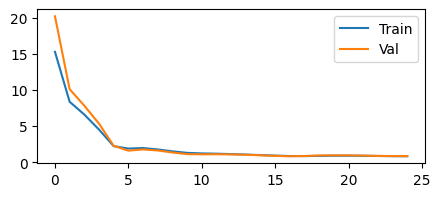

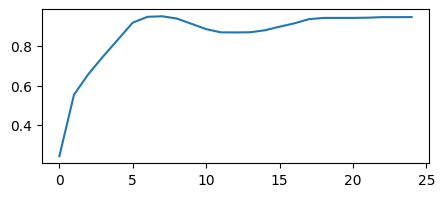

Epoch 30 loss: 0.841, (rate of change: -0.0002), val accuracy: 0.955 (best: 0.956)
            -- Average time per epoch: 0.9sec (last 5: 0.8sec).            Estimated time to end: 2 mins
Epoch 40 loss: 0.817, (rate of change: -0.0014), val accuracy: 0.896 (best: 0.956)
            -- Average time per epoch: 0.9sec (last 5: 0.9sec).            Estimated time to end: 2 mins
Epoch 50 loss: 0.793, (rate of change: -0.0016), val accuracy: 0.910 (best: 0.956)
            -- Average time per epoch: 0.9sec (last 5: 0.8sec).            Estimated time to end: 1 mins


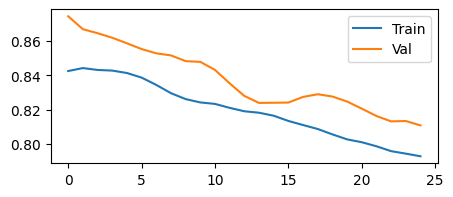

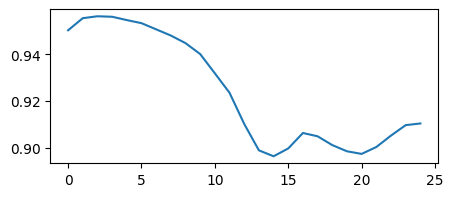

Epoch 60 loss: 0.778, (rate of change: -0.0011), val accuracy: 0.912 (best: 0.956)
            -- Average time per epoch: 0.9sec (last 5: 0.9sec).            Estimated time to end: 1 mins
Epoch 70 loss: 0.765, (rate of change: -0.0011), val accuracy: 0.915 (best: 0.956)
            -- Average time per epoch: 0.9sec (last 5: 0.9sec).            Estimated time to end: 1 mins


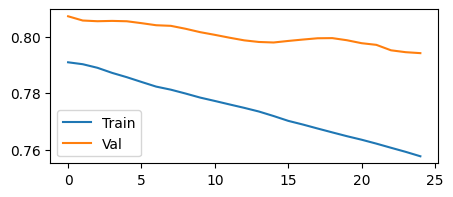

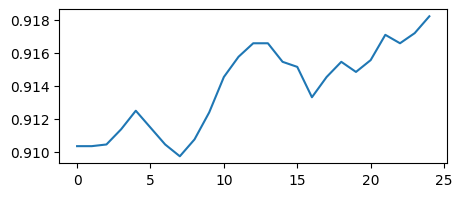

Epoch 80 loss: 0.752, (rate of change: -0.0009), val accuracy: 0.920 (best: 0.956)
            -- Average time per epoch: 0.9sec (last 5: 0.7sec).            Estimated time to end: 1 mins
Epoch 90 loss: 0.740, (rate of change: -0.0010), val accuracy: 0.918 (best: 0.956)
            -- Average time per epoch: 0.9sec (last 5: 0.8sec).            Estimated time to end: 1 mins
Epoch 100 loss: 0.730, (rate of change: -0.0009), val accuracy: 0.913 (best: 0.956)
            -- Average time per epoch: 0.9sec (last 5: 1.0sec).            Estimated time to end: 1 mins


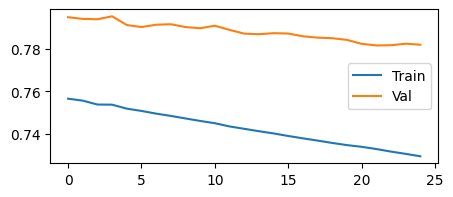

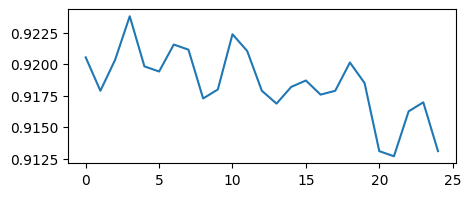

Epoch 110 loss: 0.715, (rate of change: -0.0011), val accuracy: 0.905 (best: 0.956)
            -- Average time per epoch: 0.9sec (last 5: 1.3sec).            Estimated time to end: 1 mins
Epoch 120 loss: 0.703, (rate of change: -0.0009), val accuracy: 0.905 (best: 0.956)
            -- Average time per epoch: 0.9sec (last 5: 0.7sec).            Estimated time to end: 0 mins


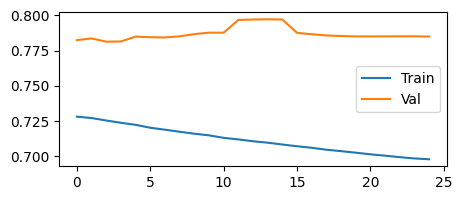

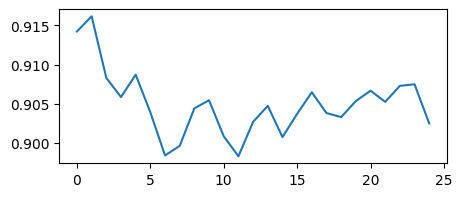

Epoch 130 loss: 0.693, (rate of change: -0.0006), val accuracy: 0.912 (best: 0.956)
            -- Average time per epoch: 0.9sec (last 5: 0.8sec).            Estimated time to end: 0 mins
Epoch 140 loss: 0.685, (rate of change: -0.0007), val accuracy: 0.910 (best: 0.956)
            -- Average time per epoch: 0.9sec (last 5: 0.8sec).            Estimated time to end: 0 mins
Epoch 150 loss: 0.674, (rate of change: -0.0008), val accuracy: 0.909 (best: 0.956)
            -- Average time per epoch: 0.9sec (last 5: 0.7sec).            Estimated time to end: 0 mins


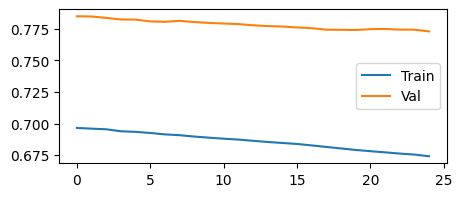

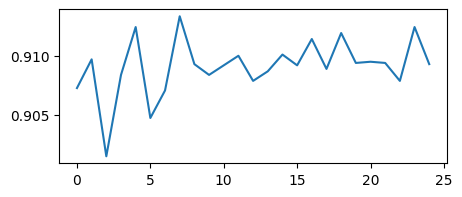

------------------------------------------------------------
Training complete.     Final loss: 0.674,     final val accuracy: 0.909, (best: 0.956).


In [21]:
QUICK_TEST = False
if QUICK_TEST:
    n_ep = 2
else:
    n_ep = NUM_EPOCHS

probs, preds, history = train(model, g, n_ep, labels, train_mask, val_mask, 0.5)


In [22]:
print('Training set: mean of probabilities, predictions, and true labels:')
print(probs[train_mask].mean())
print(preds[train_mask].mean())
print(labels[train_mask].mean())
print('\nValidation set:')
print(probs[val_mask].mean())
print(preds[val_mask].mean())
print(labels[val_mask].mean())
print('Evaluation of validation set results:\n','-'*50)

Training set: mean of probabilities, predictions, and true labels:
tensor(0.2291, grad_fn=<MeanBackward0>)
tensor(0.0643)
tensor(0.0282)

Validation set:
tensor(0.2429, grad_fn=<MeanBackward0>)
tensor(0.0857)
tensor(0.0291)
Evaluation of validation set results:
 --------------------------------------------------


In [23]:
print(f"Proportion of transactions predicted as fraud: {torch.mean(preds[val_mask])*100:.2f} %.")
cm = confusion_matrix(preds[val_mask], labels[val_mask])
print(cm)
fp_rate = cm[1,0]/(cm[1,0]+cm[1,1])
print(f"False positive rate: {fp_rate*100:.1f} %. ")
fn_rate = cm[0,1]/(cm[0,1]+cm[0,0])
print(f"False negative rate: {fn_rate*100:.2f} %. ")
tn_rate = 1-fp_rate
print(f"True negative rate: {tn_rate*100:.2f} % (specificity). ")
tp_rate = 1- fn_rate
print(f"True positive rate: {tp_rate*100:.2f} % (sensitivity). ")

Proportion of transactions predicted as fraud: 8.57 %.
[[8797  167]
 [ 722  118]]
False positive rate: 86.0 %. 
False negative rate: 1.86 %. 
True negative rate: 14.05 % (specificity). 
True positive rate: 98.14 % (sensitivity). 


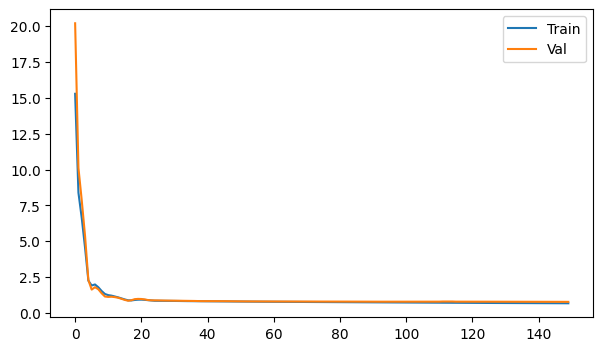

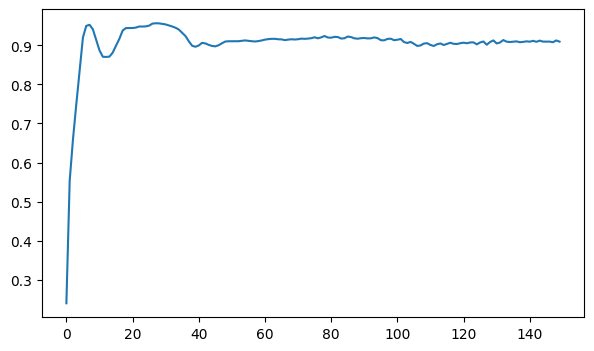

In [24]:
loss_history_plot(history['loss'], history['val_loss'])
loss_history_plot(history['val_acc'])